# Báo cáo Project
Lớp TTNT-162297, Nhóm G02

## 1. Thông tin chung

### Thành viên
- Vũ Văn An 202416109
- Nguyễn Gia Bách 202416130
- Vũ Hòa Bình 202416137
- Nguyễn Nhật Minh 202416291

### Lịch thực hiện
- W02: Đăng ký nhóm 
- W03: Đề xuất project (28/9)
- W08: Báo cáo tiến độ giữa kỳ (1/11)
- W15: Hoàn thành và gửi báo cáo project (20/12)
- W16-18: Trình bày project, Q&A

## 2. Chi tiết phương pháp, dữ liệu

### I. Giới thiệu trò chơi và mục tiêu dự án

**PokerBot (Texas Hold’em)** là một dự án xây dựng người chơi tự động có khả năng ra quyết định thông minh trong trò chơi Poker – môi trường có tính bất định cao và đòi hỏi tư duy chiến lược.  
Mục tiêu của dự án là **phát triển bot có thể phân tích tình huống, ước lượng xác suất thắng và lựa chọn hành động tối ưu** (*fold, call, raise*) dựa trên các yếu tố như **pot odds, EV (expected value)** và **xác suất thắng**.  

Trò chơi Poker là bài toán lý tưởng để thử nghiệm **thuật toán tìm kiếm và ra quyết định trong trí tuệ nhân tạo**, vì nó kết hợp các yếu tố: thông tin ẩn, không gian trạng thái lớn và rủi ro ngẫu nhiên.  
Dự án giúp sinh viên hiểu rõ cách AI xử lý các bài toán chiến lược, xác suất và tối ưu hành động trong môi trường không chắc chắn.
### II. Kiến trúc chương trình – PokerBot (Texas Hold’em)

#### 1. Mục tiêu
Tổ chức mã nguồn theo module:  
- `PokerGame`: điều phối ván đấu, xử lý vòng cược, chia bài, showdown.  
- `Player`: lưu trạng thái từng người chơi (tên, tiền, hand, hành động).  
- `bot.py`: AI module — tính xác suất thắng, EV, chọn hành động tối ưu.  
- `treys`: thư viện hỗ trợ tạo bộ bài và đánh giá sức mạnh hand.  

---

#### 2. Sơ đồ khối
```
+-----------------+    +--------------------+    +--------------------+
|  PokerGame      | -> |  treys (Deck/Card) | -> |  Evaluator (treys) |
| - vòng đời ván  |    | - tạo & rút bài    |    |  - so sánh hand    |
+-----------------+    +--------------------+    +--------------------+
        |
        v
+-----------------+    +--------------------+    +--------------------+
|  Player         |<-> |  bot.py (AI)       | -> |  Monte Carlo / EV  |
| - trạng thái    |    | - chọn hành động   |    |  - đánh giá state  |
+-----------------+    +--------------------+    +--------------------+
```

---

#### 3. Luồng hoạt động
1. **Khởi tạo game** → tạo deck, post blind.  
2. **Chia bài & hiển thị bàn**.  
3. **Bot** tính `win_prob` (Monte Carlo) + EV để chọn `check/call/raise/fold`.  
4. **Người chơi** phản hồi hành động.  
5. **Showdown** → so sánh bài bằng `Evaluator`.  
6. **Ghi log** (tỉ lệ thắng, thời gian, hành động) → vòng mới.  

---

#### 4. Dữ liệu & log
```python
BOT_LOG = {
  'decisions': {'fold':0,'check':0,'call':0,'raise':0},
  'win_probs': [], 'decision_times': [],
  'rounds': {'total':0,'bot_wins':0,'player_wins':0,'ties':0}
}
```
> Giúp theo dõi hiệu suất bot: tỉ lệ thắng, tốc độ phản ứng, xác suất thắng trung bình.  

--- 
### III. Thuật toán sử dụng

#### a) Monte Carlo Simulation
**Mục đích:** Ước lượng xác suất thắng của bot dựa trên việc rút ngẫu nhiên bài còn thiếu (bài đối thủ + community).  

**Công thức:**
$$
P_{\text{win}} = \frac{W + 0.5\,T}{N}
$$
Trong đó:  
- \(W\): số lần thắng  
- \(T\): số lần hoà  
- \(N\): số lần mô phỏng  

---

#### b) MiniMax và Alpha–Beta Pruning
**Giải thích cây trạng thái:**  
- Nút **MAX**: hành động của bot  
- Nút **MIN**: hành động của đối thủ (giả định chơi tối ưu)  

**Công thức tổng quát:**
$$
V(n) =
\begin{cases}
\max\limits_{a \in \text{Actions}} V(\mathrm{Result}(n,a)), & \text{(MAX node)} \\
\min\limits_{a \in \text{Actions}} V(\mathrm{Result}(n,a)), & \text{(MIN node)}
\end{cases}
$$

##### 🔪 Cắt tỉa α–β

- **α (alpha):** giá trị tốt nhất mà **MAX** có thể đảm bảo.  
- **β (beta):** giá trị tốt nhất mà **MIN** có thể đảm bảo.  
- Nếu $\beta \le \alpha$ ⇒ **cắt nhánh** *(không cần duyệt tiếp)*.  

Cơ chế cắt tỉa giúp giảm mạnh số lượng nút phải duyệt trong cây tìm kiếm Minimax,  
giữ nguyên kết quả tối ưu nhưng rút ngắn thời gian tính toán đáng kể.

---

#### c) Hàm đánh giá trạng thái (Evaluation Function)
**Thành phần chính:**

1. **Monte Carlo win\_prob** \([0,1]\): xác suất thắng hiện tại.  

2. **Pot odds** – tỷ lệ rủi ro khi call:  
   $$
   \text{to\_call} = \max(0,\, \text{current\_bet} - \text{my\_current\_bet})
   $$
   $$
   \text{pot\_after} = \text{pot} + \text{to\_call}
   $$
   $$
   \text{pot\_odds} = \frac{\text{to\_call}}{\text{pot\_after} + \varepsilon}
   $$

3. **EV (Expected Value) khi call** (xấp xỉ):  
   $$
   EV_{\text{call}} = P_{\text{win}} \cdot \text{pot\_after} - (1 - P_{\text{win}}) \cdot \text{to\_call}
   $$

4. **Money ratio / bankroll factor:** lợi thế vốn (tùy chọn).

---

**Hàm điểm tổng hợp:**
$$
\text{score}
= 0.68 \times P_{\text{win}}
+ 0.25 \times \tanh\!\left(\frac{EV_{\text{call}}}{20}\right)
+ 0.07 \times \text{money\_factor}
+ \text{risk\_penalty}
$$


Hàm này cho phép bot kết hợp giữa xác suất thắng, kỳ vọng giá trị và yếu tố tài chính để chọn hành động hợp lý nhất (fold / call / raise).  




### Phân công
- Bình & Nhật Minh: Lên ý tưởng và code.
- An & Bách: Chuẩn bị tài liệu & hỗ trợ.

## 3. Chương trình

**Note:** tốc độ chạy khoảng 1 ván/phút

In [1]:
# Clone the repository
!git clone https://github.com/NhatMinh0311/G02_PokerBot

# Using pip
!pip install pygame treys

### Run the Game
import os

os.chdir("./G02_PokerBot")
# Using python directly
!python src/autotest.py

Cloning into 'G02_PokerBot'...


🤖 PokerBot Automated Testing


📋 Available Bot Configurations:

  • BASIC
    - Depth: 2 (searches 2 moves ahead)
    - Simulations: 100 (Monte Carlo runs per decision)
    - Difficulty: ⭐⭐ Medium

  • ADVANCED
    - Depth: 5 (searches 5 moves ahead)
    - Simulations: 500 (Monte Carlo runs per decision)
    - Difficulty: ⭐⭐⭐⭐ Expert

🎮 Test Settings:
  - Games per test: 10
  - Rounds per game: 20
  - Starting money: $100
  - Blinds: $2/$5


🎮 Testing: BASIC vs ADVANCED
   basic: depth=2, sims=100
   advanced: depth=5, sims=500
   Games: 10, Rounds: 20

Game 1/10:  ✓ advanced ($0 vs $200)
Game 2/10:  ✓ basic ($200 vs $0)
Game 3/10:  ✓ advanced ($0 vs $200)
Game 4/10: . ✓ advanced ($0 vs $199)
Game 5/10:  ✓ advanced ($0 vs $200)
Game 6/10:  ✓ basic ($200 vs $0)
Game 7/10: .. ✓ basic ($198 vs $0)
Game 8/10:  ✓ advanced ($0 vs $200)
Game 9/10:  ✓ advanced ($0 vs $200)
Game 10/10:  ✓ basic ($200 vs $0)

📊 RESULTS:
  basic: 4 wins (40.0%)
  advanced: 6 wins (60.0%)

📈 STATISTICS:
  Basic:
 

## 4. Phân tích, đánh giá kết quả 

### I. Mức độ hoàn thiện sản phẩm
Sản phẩm PokerBot đã hoàn thành đầy đủ mục tiêu đề ra là mô phỏng một ván Texas Hold’em Poker cơ bản và xây dựng bot có khả năng tự động ra quyết định. Trò chơi bao gồm đầy đủ các giai đoạn chia bài, flop, turn, river, vòng cược và so sánh hand để xác định người thắng. Bot có thể thực hiện các hành động fold, call và raise một cách độc lập mà không cần sự can thiệp của người chơi.

Luồng xử lý của trò chơi được xây dựng rõ ràng và nhất quán. Các thành phần như tiền cược, pot, số vòng chơi và trạng thái người chơi được cập nhật chính xác sau mỗi hành động. Trong quá trình mô phỏng nhiều ván liên tiếp, hệ thống vận hành ổn định và không phát sinh lỗi logic nghiêm trọng.

### II. Chất lượng thuật toán và trí tuệ của bot
Thuật toán ra quyết định:
    Bot sử dụng phương pháp Monte Carlo Simulation để ước lượng xác suất thắng dựa trên hand hiện tại và các lá bài cộng đồng. Trên cơ sở đó, thuật toán Minimax kết hợp cắt tỉa Alpha–Beta được áp dụng để đánh giá và lựa chọn hành động tối ưu. Ngoài xác suất thắng, bot còn xem xét Expected Value (EV) và tình trạng tiền của hai bên, giúp quyết định mang tính chiến lược thay vì ngẫu nhiên.
#### 1. Tỷ lệ thắng (Win Rate)

**Mục đích:** Đo xem bot có chơi tốt hơn ngẫu nhiên hay không.

- **Win rate (%) = số ván thắng / tổng số ván**
- So sánh:
    - **Bot vs Player** 
  
    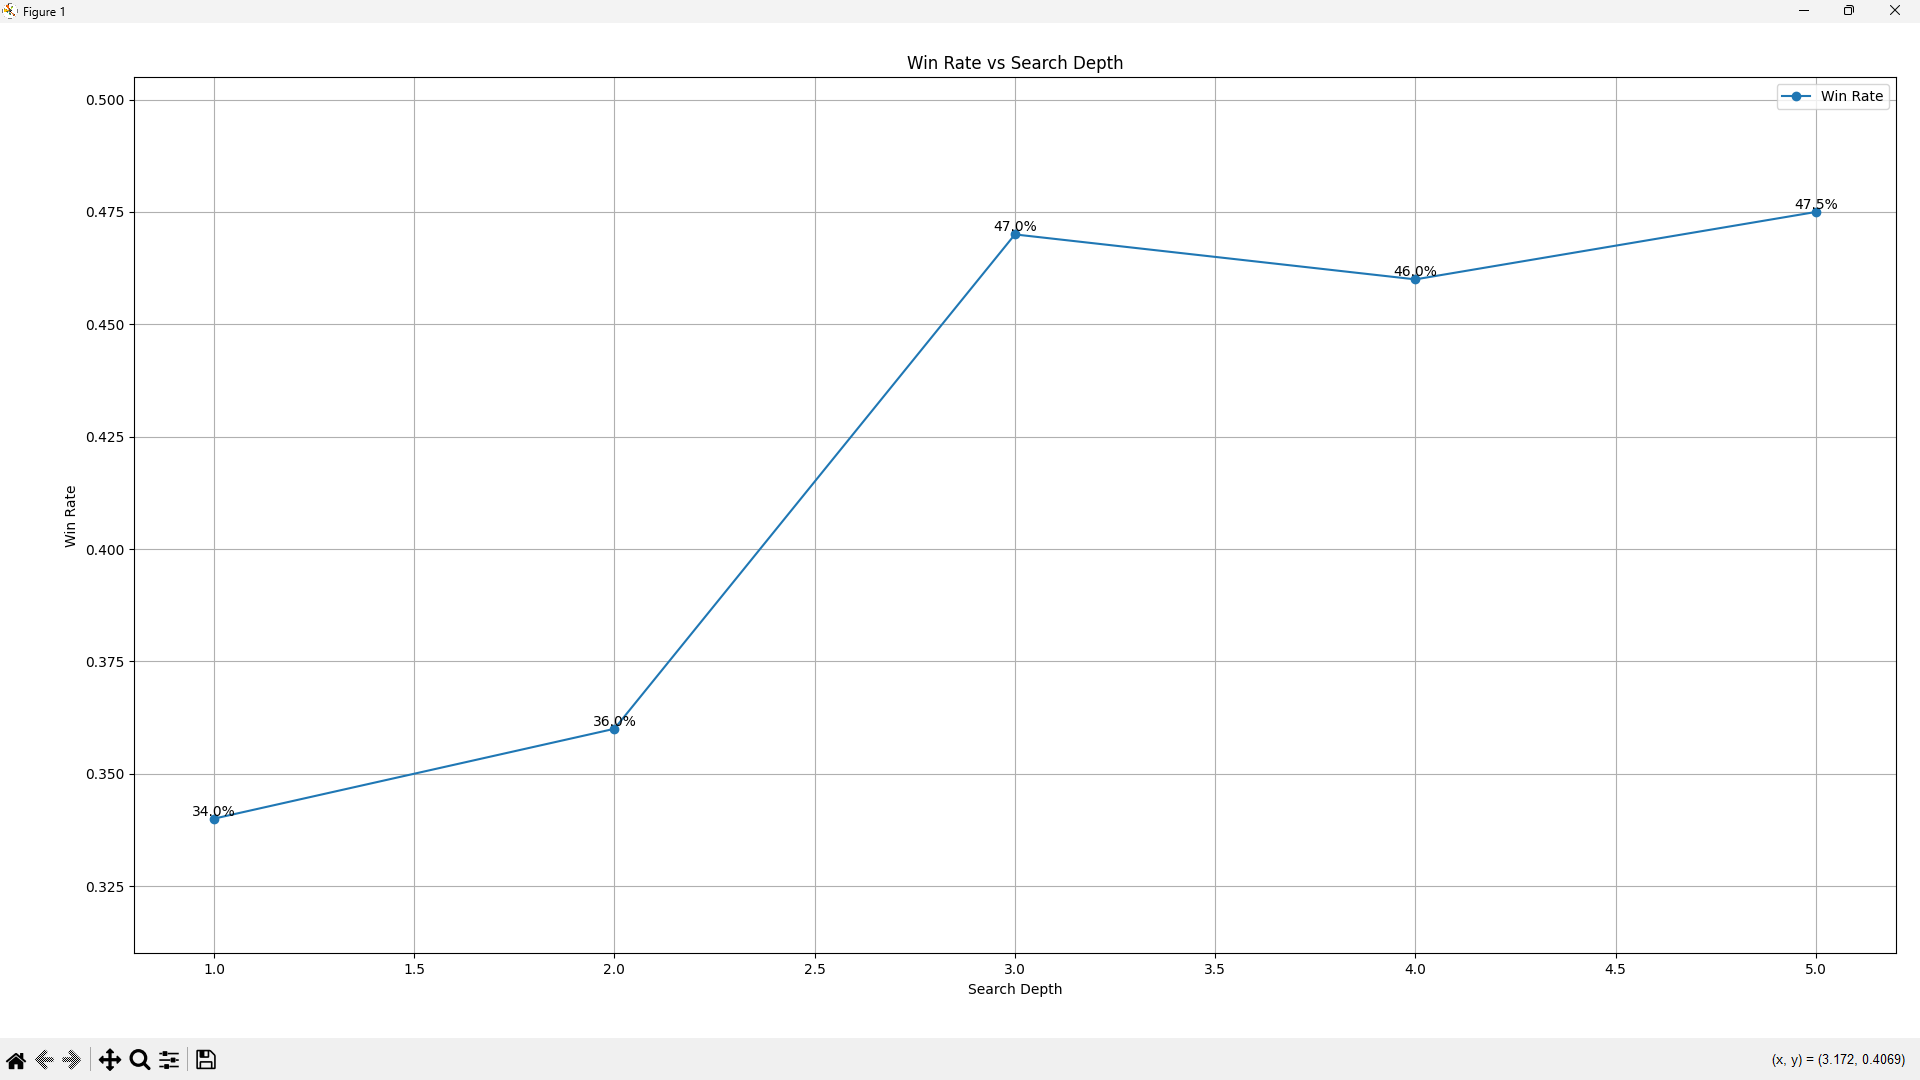

    - **Bot vs Bot**  

    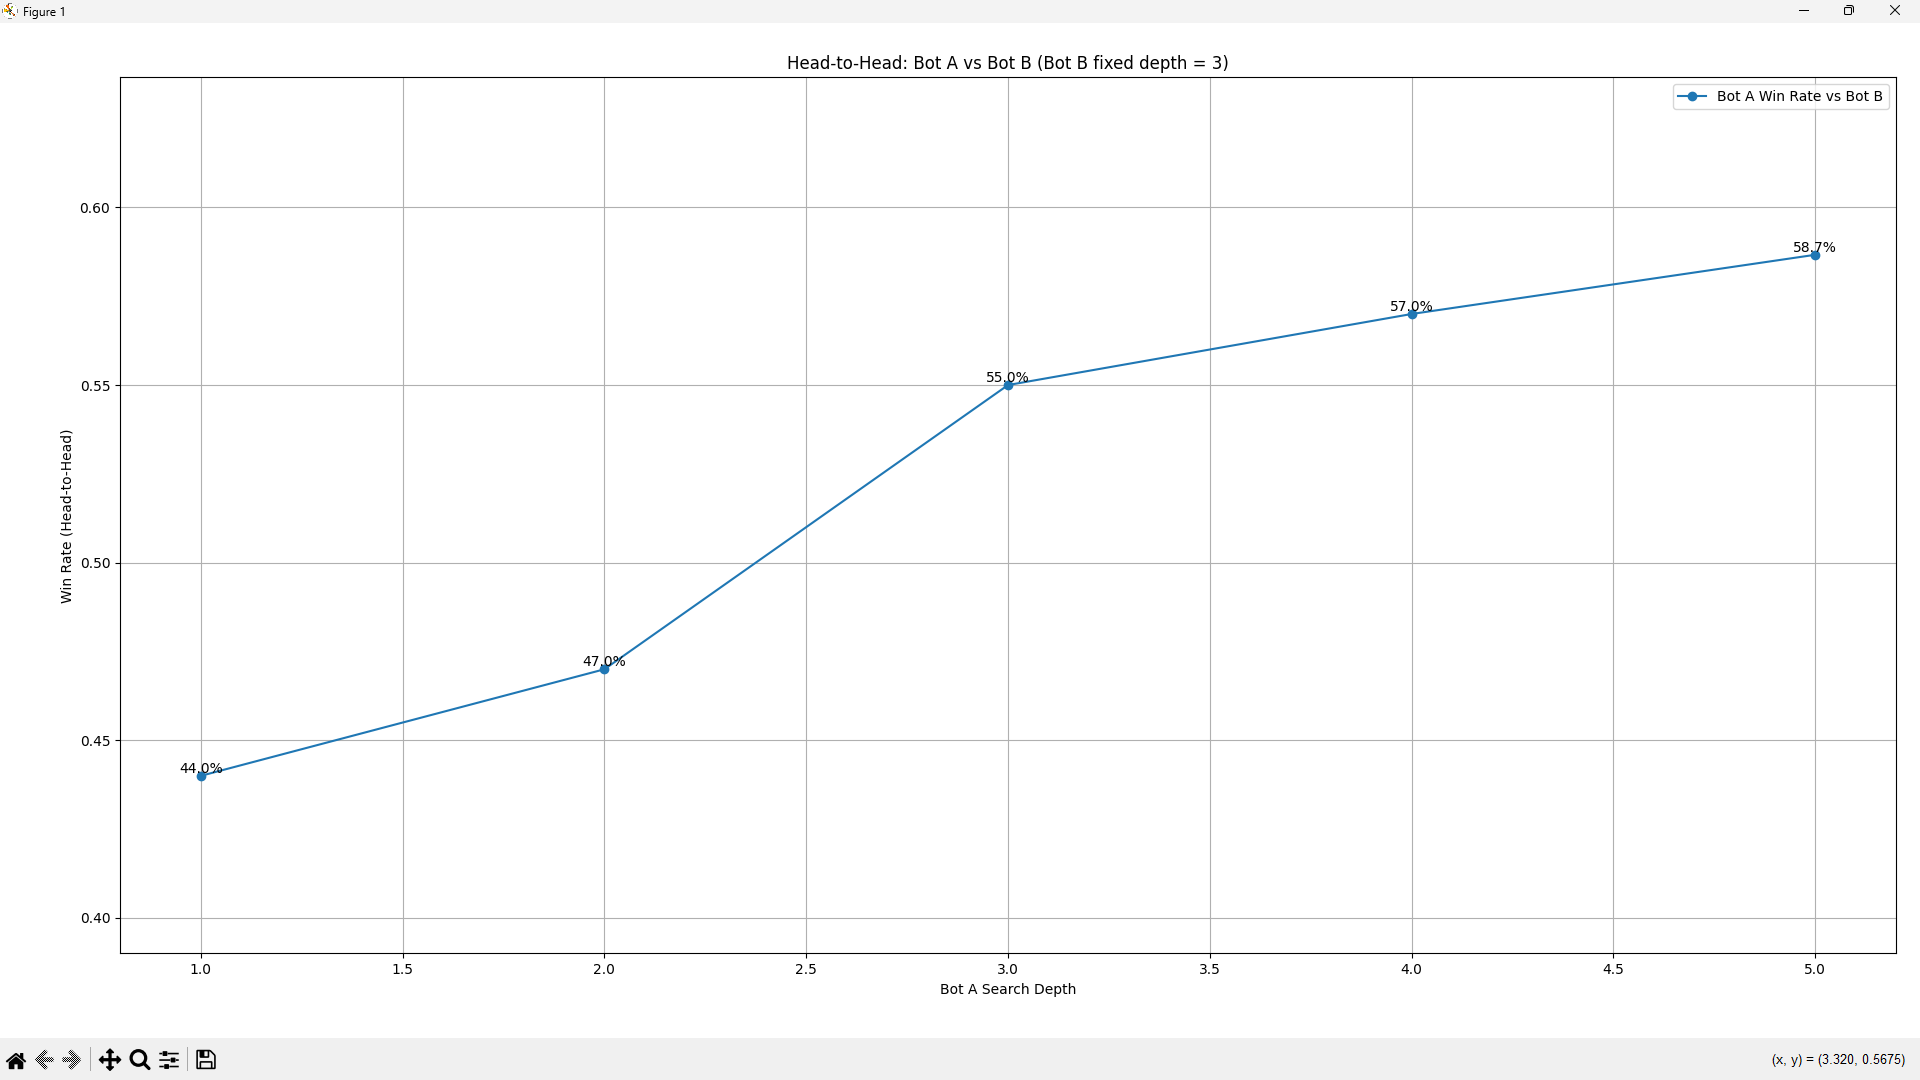

$\Rightarrow$ Bot có depth cao hơn có tỉ lệ thắng cao hơn, ở những khoảng depth = 4 trở lên sẽ có tỉ lệ thắng tương tự nhau và sẽ gần với 0.5

#### 2. Lợi nhuận ròng (Net Profit)

**Mục đích:** Thắng nhiều chưa chắc hiệu quả, quan trọng là **tiền kiếm được**.

- **Net profit = Tổng tiền thắng − Tổng tiền thua**
- **Profit per game = Net profit / số ván**
- **Profit per win = Net profit / số ván thắng**

- So sánh:
    - **Bot vs Bot** (Bot B's depth = 3)

    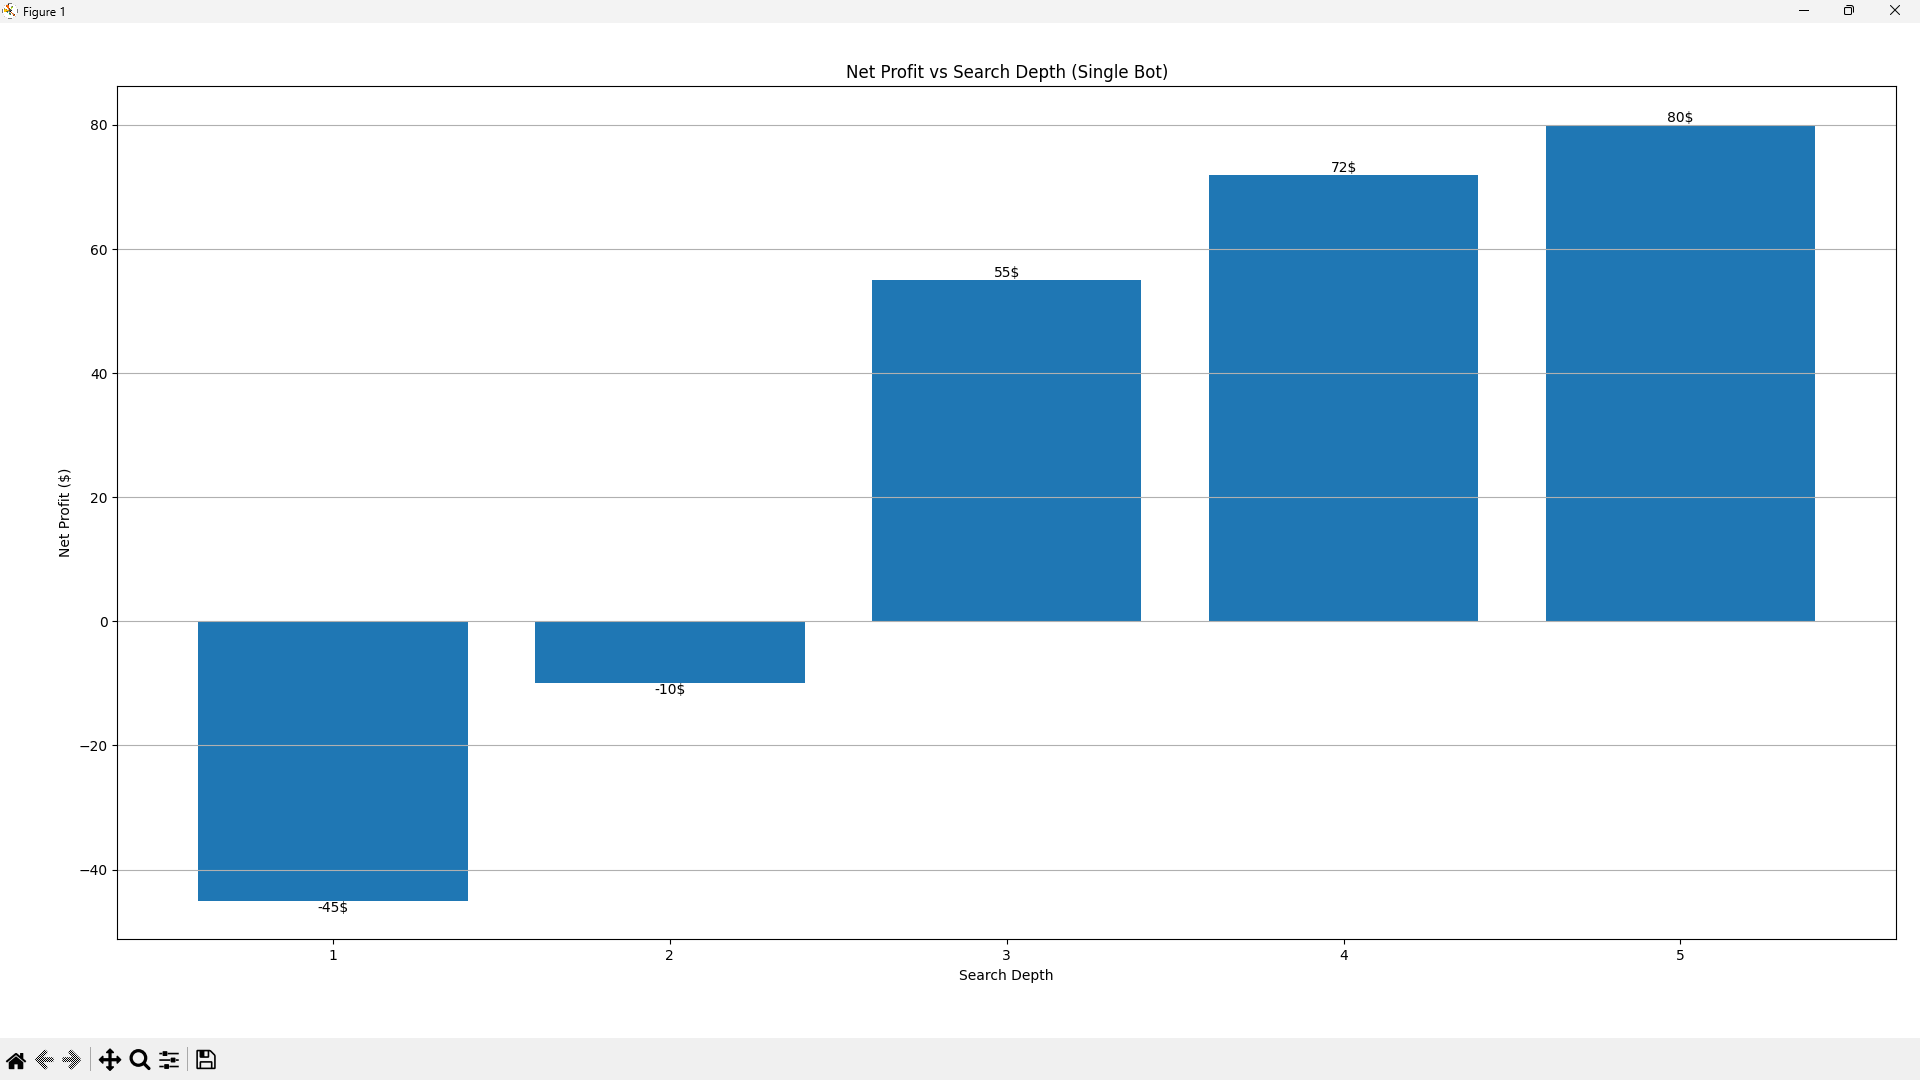

$\Rightarrow$ Bot có depth cao hơn kiếm được nhiều tiền hơn 

#### 3. Hiệu quả trên mỗi quyết định (Efficiency per Decision)

**Mục đích:** Đánh giá bot không chỉ thắng, mà thắng **hiệu quả**, tránh việc ra quá nhiều quyết định nhưng lợi nhuận thu về thấp.

- **Profit per decision = Net profit / số quyết định**

**Ý nghĩa:**
- Chỉ số này cho biết **mỗi hành động của bot mang lại bao nhiêu lợi nhuận trung bình**.
- Bot có **profit per decision cao** thường đưa ra quyết định có chọn lọc, không spam raise hoặc kéo dài ván đấu không cần thiết.
- Ngược lại, profit per decision thấp cho thấy bot ra nhiều quyết định nhưng hiệu quả thấp, làm tăng chi phí tính toán mà không tương xứng với lợi ích đạt được.

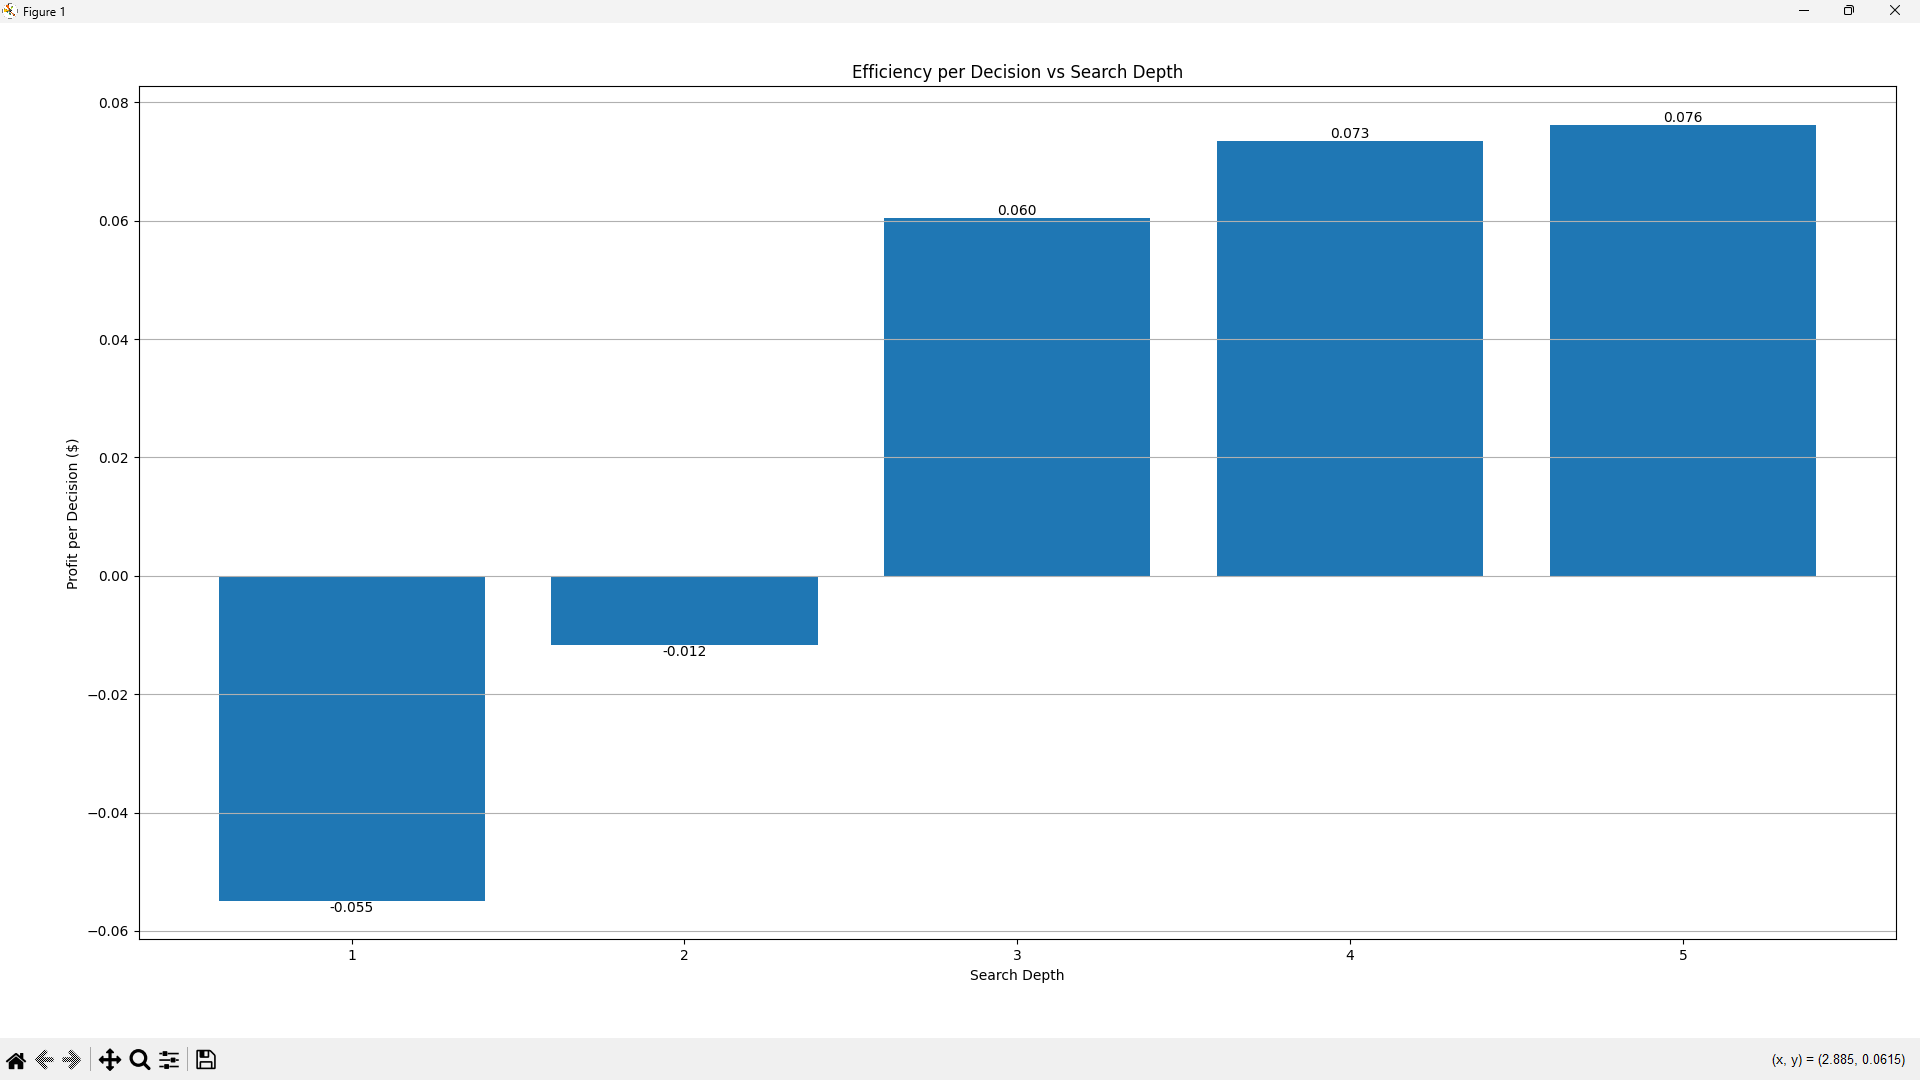

**Phân tích** – Hiệu quả trên mỗi quyết định (Efficiency per Decision)

Từ bảng kết quả và đồ thị, có thể rút ra các điểm chính sau:

- Ở **depth thấp (1–2)**, chỉ số **Profit per Decision** còn thấp (thậm chí âm).
  - Điều này cho thấy bot ra quyết định chưa hiệu quả: dù đưa ra nhiều hành động, lợi nhuận thu về không tương xứng.

- Ở **depth trung bình (3–4)**, **Profit per Decision tăng rõ rệt**.
  - Đây là giai đoạn bot bắt đầu tận dụng tốt hơn việc tìm kiếm sâu và mô phỏng (Monte Carlo/Minimax), giúp lựa chọn hành động hợp lý hơn.

- Ở **depth cao (5)**, lợi nhuận vẫn tăng nhưng mức tăng **bắt đầu bão hòa**.
  - Nghĩa là: độ sâu tăng thêm không còn cải thiện hiệu quả trên mỗi quyết định nhiều như trước.
  - Trong thực tế, đây là dấu hiệu tồn tại một **sweet spot**: depth vừa đủ để bot chơi tốt nhưng không tốn chi phí tính toán quá lớn.

**Kết luận:**
Bot không chỉ thắng, mà còn thắng **hiệu quả hơn trên mỗi quyết định** khi tăng depth. Tuy nhiên, khi depth quá cao, hiệu quả tăng chậm dần, vì vậy nên chọn depth ở vùng trung bình–cao (ví dụ 3–4 hoặc 5 tùy cấu hình) để cân bằng giữa chất lượng và tốc độ.

#### 4. Phân bố hành động (Action Distribution)

**Mục đích:** Đánh giá cách bot lựa chọn hành động trong quá trình chơi, từ đó kiểm tra mức độ hợp lý và cân bằng trong chiến lược.

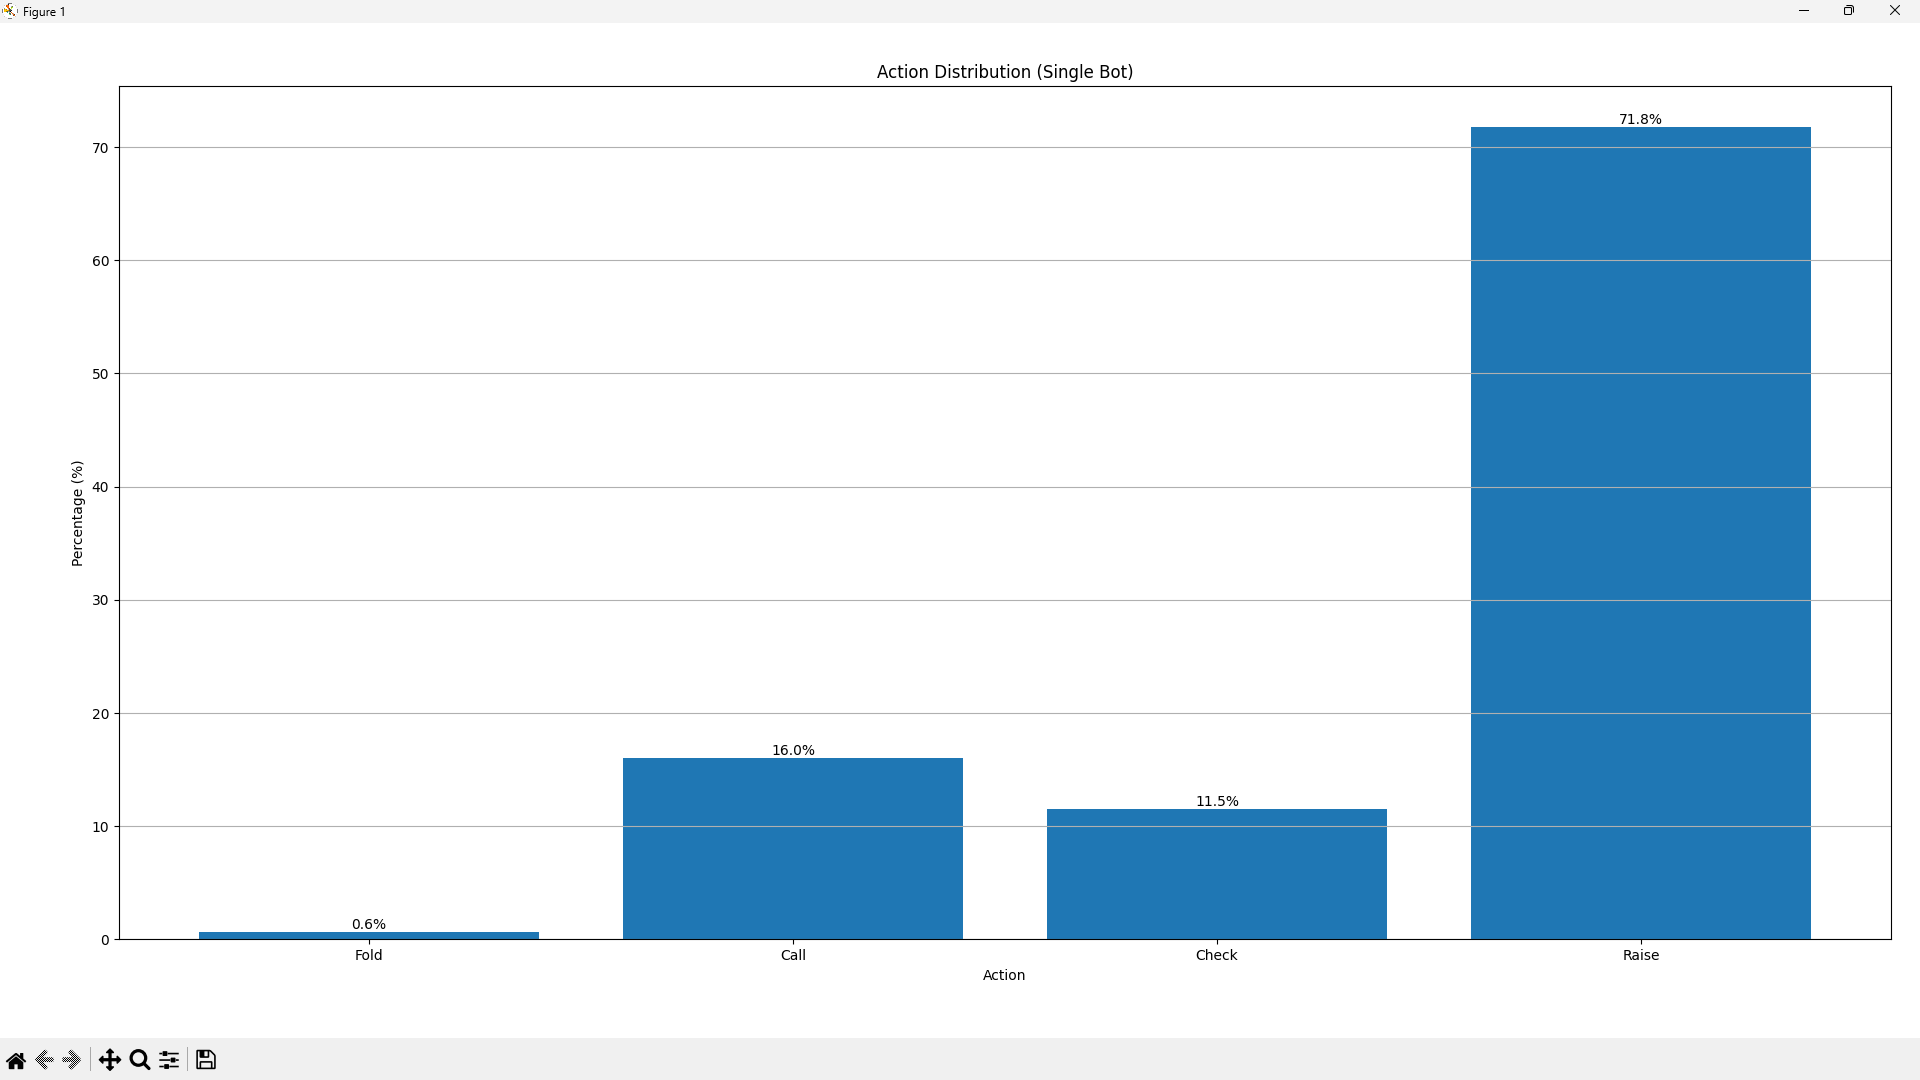

**Nhận xét / Ý nghĩa rút ra từ phân bố hành động**
Kết quả cho thấy bot có xu hướng **rất thiên về tấn công**, với tỉ lệ **Raise chiếm khoảng 71.8%**, trong khi **Fold gần như bằng 0%**.  
Điều này cho thấy bot hầu như luôn tham gia ván đấu và thường xuyên gây áp lực lên đối thủ.

Tuy nhiên, tỉ lệ **Call (16.0%)** và **Check (11.5%)** khá thấp, cho thấy bot **thiếu các hành động trung hòa** để kiểm soát pot và giảm rủi ro.  
Chiến lược này có thể mang lại lợi nhuận trong ngắn hạn, nhưng về lâu dài dễ dẫn đến **over-aggressive** và kém ổn định.

**Kết luận:** Bot cần cân bằng hơn giữa **Raise / Call / Check** và tăng tỉ lệ **Fold** ở các tình huống bất lợi để chiến lược bền vững hơn.